# Modeling Daily Passenger Counts with Machine Learning

The goal of this notebook is to model and compare different Machine Learning approaches using the `global_daily_df` dataset.  
This dataset aggregates daily passenger counts (boardings and alightings) across the entire TPG network.  

The objectives are:  
- to evaluate the ability of different models to capture temporal and contextual patterns in the data,  
- to compare their performance using standard metrics (MAE, RMSE, R²),  


This work will provide insights into the strengths and limitations of several Machine Learning models when applied to public transport demand forecasting.  

### Method :  
We will implement and compare several Machine Learning models, using a consistent pipeline for preprocessing and evaluation. 

### Remark :  
The analysis is limited to daily aggregated data.  
Stop-level details are addressed in the next notebook.  

In [1]:
# libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Loading the data

In [2]:
global_daily_df = pd.read_csv("global_daily_df.csv",sep=",")
global_daily_df['date'] = pd.to_datetime(global_daily_df['date'])
display(global_daily_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415 entries, 0 to 1414
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            1415 non-null   datetime64[ns]
 1   nb_de_montees                   1415 non-null   float64       
 2   nb_de_descentes                 1415 non-null   float64       
 3   frequentation_totale            1415 non-null   float64       
 4   frequentation_totale_lag_1      1415 non-null   float64       
 5   frequentation_totale_lag_7      1415 non-null   float64       
 6   rolling_mean_7d                 1415 non-null   float64       
 7   weather_code                    1415 non-null   int64         
 8   log_frequentation_totale        1415 non-null   float64       
 9   log_frequentation_totale_lag_1  1415 non-null   float64       
 10  log_frequentation_totale_lag_7  1415 non-null   float64       
 11  log_

None

In [3]:
print(f"The data covers the date range from {global_daily_df['date'].min()} to {global_daily_df['date'].max()}")

The data covers the date range from 2021-08-08 00:00:00 to 2025-06-22 00:00:00


# 2) Splitting the data


### Observation :  
For a time series, the chronological order must be preserved — we do not shuffle the rows.  
The dataset should be split sequentially into **train → validation → test**.  

### Method :  
Two approaches can be used:  

1. **Fixed split** by defining explicit temporal boundaries.  
2. **TimeSeriesSplit for cross-validation**, which allows splitting the training set into several train/validation folds while preserving temporal order.

## a) Fixed split

In [4]:
# Définition des bornes temporelles
train_end = pd.to_datetime('2023-12-31')
valid_start = pd.to_datetime('2024-01-01')
valid_end = pd.to_datetime('2024-06-30')
test_start = pd.to_datetime('2024-07-01')
test_end = pd.to_datetime('2025-06-22')

def split_dataset(dataset):
    train_df = dataset[dataset['date'] <= train_end] 
    valid_df = dataset[(dataset['date'] >= valid_start) & (dataset['date'] <= valid_end)] 
    test_df  = dataset[(dataset['date'] >= test_start) & (dataset['date'] <= test_end)]
    return train_df, valid_df, test_df
    
# Découpage de global_daily_df
global_train_df, global_valid_df, global_test_df = split_dataset(global_daily_df)

# Découpage de TPG_meteo_all_df
# tpg_train_df, tpg_valid_df, tpg_test_df = split_dataset(TPG_meteo_all_df)


# Affichage des tailles pour vérification
print("GLOBAL DAILY SPLIT:")
print(f"Train: {len(global_train_df)} jours")
print(f"Valid: {len(global_valid_df)} jours")
print(f"Test : {len(global_test_df)} jours\n")

# print("TPG + METEO SPLIT:")
# print(f"Train: {len(tpg_train_df)} lignes")
# print(f"Valid: {len(tpg_valid_df)} lignes")
# print(f"Test : {len(tpg_test_df)} lignes")

GLOBAL DAILY SPLIT:
Train: 876 jours
Valid: 182 jours
Test : 357 jours



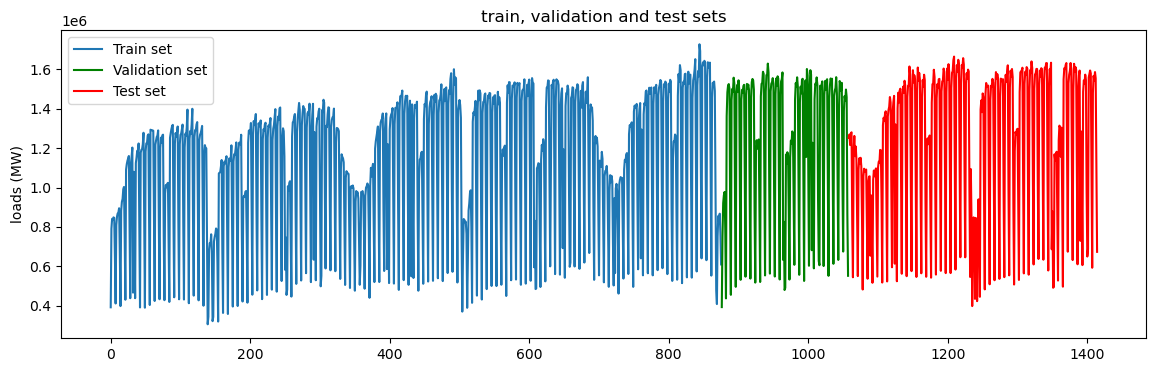

In [5]:
# Plot training and test sets
fig = plt.figure(figsize=(14, 4))
plt.plot(global_train_df.frequentation_totale, label="Train set")
plt.plot(global_valid_df.frequentation_totale, label="Validation set", color="g")
plt.plot(global_test_df.frequentation_totale, label="Test set", color="r")

plt.title("train, validation and test sets")
plt.ylabel("loads (MW)")
plt.legend()
plt.show()

## b) TimeSeriesSplit for cross-validation

In [6]:
#  load the library
from sklearn.model_selection import TimeSeriesSplit

train = global_daily_df.loc[global_daily_df['date'] <= "2024-06-30"].reset_index(drop=True)
test  = global_daily_df.loc[global_daily_df['date'] >= "2024-07-01"].reset_index(drop=True)


# Split train set into train/validation sets
cv = TimeSeriesSplit(n_splits=5)

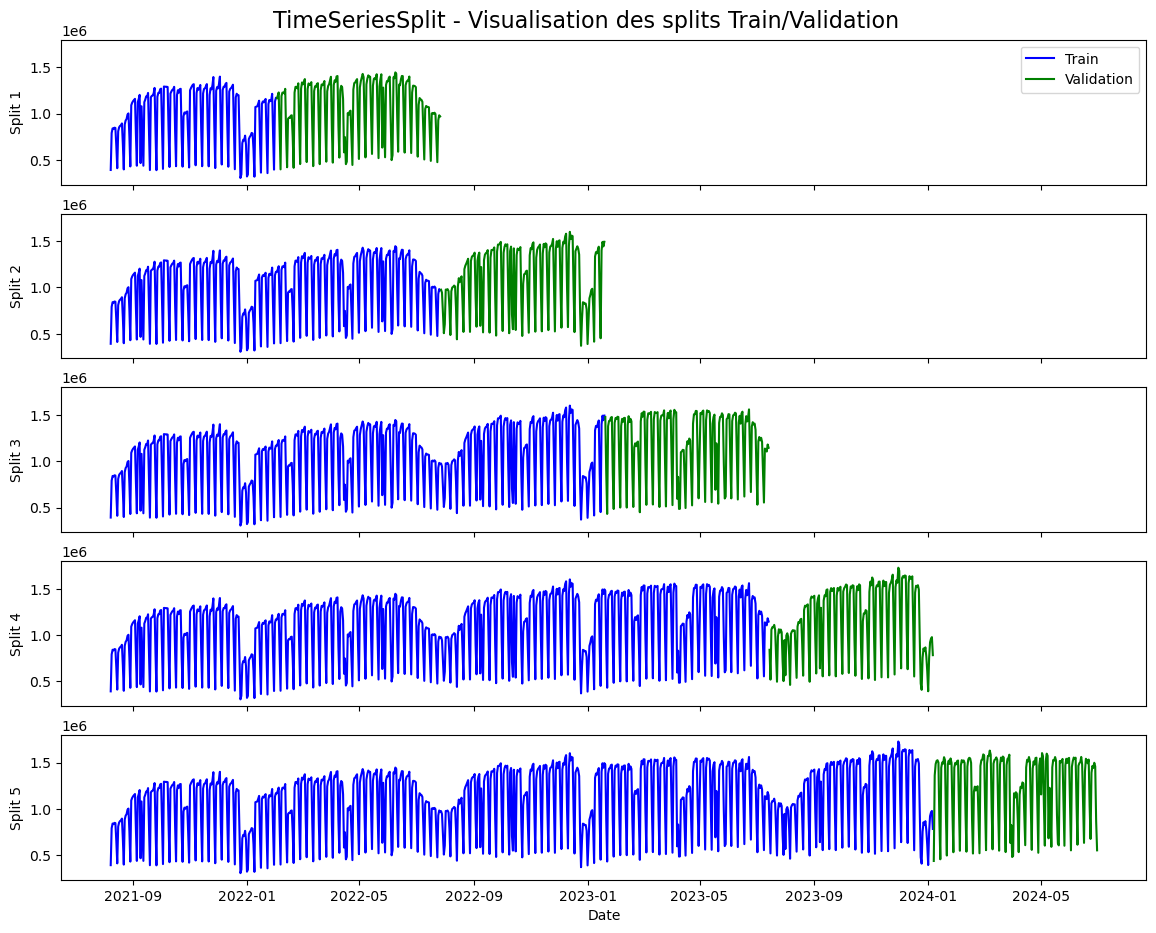

In [7]:
# Plot iterations of the training and validation sets

# Création du graphique
fig, axes = plt.subplots(5, 1, figsize=(14, 10), sharex=True, sharey=True)
plt.suptitle("TimeSeriesSplit - Visualisation des splits Train/Validation", fontsize=16)

for i, (tr_idx, val_idx) in enumerate(cv.split(train)):
    ax = axes[i]

    # Affichage avec dates en abscisse
    ax.plot(train["date"].iloc[tr_idx], train["frequentation_totale"].iloc[tr_idx], label="Train", color="blue")
    ax.plot(train["date"].iloc[val_idx], train["frequentation_totale"].iloc[val_idx], label="Validation", color="green")
    ax.set_ylabel(f"Split {i+1}")

axes[-1].set_xlabel("Date")
axes[0].legend()
plt.subplots_adjust(top=0.95)
plt.show()

### Conclusion :  
Since the data are continuous over the entire period, the `global_daily_df` dataset will be split using **TimeSeriesSplit**.  
This approach allows the model to be trained and validated across 5 sequential cycles, while preserving temporal order.  

In [8]:
# Liste des features (version log pour les séries temporelles)
features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'indice_jour_semaine',
    'indice_semaine',
    'mois',
    'annee',
    'est_weekend',
    'est_ferie'
]

target = 'log_frequentation_totale'

# Définition des jeux de données
X_tr = train[features]
y_tr = train[target]

X_te = test[features]
y_te = test[target]

X_tr.head()

,log_frequentation_totale_lag_1,log_frequentation_totale_lag_7,log_rolling_mean_7d,indice_jour_semaine,indice_semaine,mois,annee,est_weekend,est_ferie
0,13.202760,12.834165,13.461451,6,31,8,2021,1,0
1,12.878287,13.522369,13.470585,0,32,8,2021,0,0
2,13.581051,13.589748,13.479297,1,32,8,2021,0,0
3,13.642689,13.582402,13.487801,2,32,8,2021,0,0
4,13.634925,13.612583,13.494145,3,32,8,2021,0,0


# 3) Baseline model

We begin with a very simple model: using only the mean value.  

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_statistics(model_name, y_te, y_te_pred_log) : 
    mae_log = mean_absolute_error(y_te, y_te_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_te, y_te_pred_log))
    r2_log = r2_score(y_te, y_te_pred_log)

    print(f"{model_name} (log space):")
    print(f"  MAE : {mae_log:.4f}")
    print(f"  RMSE: {rmse_log:.4f}")
    print(f"  R²  : {r2_log:.4f}")


    y_te_pred_real = np.exp(y_te_pred_log)
    y_te_real = np.exp(y_te)

    
    mae_real = mean_absolute_error(y_te_real, y_te_pred_real)
    rmse_real = np.sqrt(mean_squared_error(y_te_real, y_te_pred_real))
    r2_real = r2_score(y_te_real, y_te_pred_real)

    print("\n")
    print(f"{model_name} (real space):")
    print(f"  MAE : {mae_real:.4f}")
    print(f"  RMSE: {rmse_real:.4f}")
    print(f"  R²  : {r2_real:.4f}")    
    
    return mae_log, rmse_log, r2_log, mae_real, rmse_real, r2_real


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_te_pred_log = np.median(y_tr) * np.ones(len(y_te))
#y_te_pred_real = np.median(y_tr_real) * np.ones(len(y_te_real))

base_model_name = "Baseline (median)"
base_mae_log, base_rmse_log, base_r2_log, base_mae_real, base_rmse_real, base_r2_real = compute_statistics(base_model_name, y_te, y_te_pred_log)

Baseline (median) (log space):
  MAE : 0.3015
  RMSE: 0.3827
  R²  : -0.0248


Baseline (median) (real space):
  MAE : 331204.8508
  RMSE: 378400.1937
  R²  : -0.0001


# 4) Ridge regression: linear model with regularization

Ridge regression is a regularized linear model that penalizes large coefficients.  
This reduces the impact of extreme values or highly correlated variables, and helps to limit overfitting.  

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

cat_features = ['mois', 'indice_jour_semaine', 'annee']
num_features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'est_weekend',
    'est_ferie'
]

# Define the transformer
cat_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline([("scaler", StandardScaler())])

# Apply
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Create the pipeline
pipe_ridge = Pipeline([("preprocessor", preprocessor), ("ridge", Ridge())])

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=5)  # 1 month validation , test_size=182

# Create grid for alpha
grid = {"ridge__alpha": np.logspace(-4, 4, num=20)}

# Create the grid search object
model_ridge = GridSearchCV(
    pipe_ridge,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

In [13]:
# Fit on the training set
model_ridge.fit(X_tr, y_tr)

# Evaluate on the test set
y_te_pred_log = model_ridge.predict(X_te)

ridge_model_name = "ridge regression"
ridge_mae_log, ridge_rmse_log, ridge_r2_log,ridge_mae_real, ridge_rmse_real, ridge_r2_real = compute_statistics(ridge_model_name, y_te, y_te_pred_log)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
ridge regression (log space):
  MAE : 0.0702
  RMSE: 0.1362
  R²  : 0.8702


ridge regression (real space):
  MAE : 75017.5051
  RMSE: 130343.4130
  R²  : 0.8813


In [14]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model_ridge.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_ridge__alpha",
]
cv_results[cols].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_ridge__alpha
12,-0.079444,0.006534,-0.071999,0.000692,11.288379
11,-0.080861,0.011062,-0.070305,0.001233,4.281332
13,-0.081899,0.006565,-0.078118,0.003464,29.763514
10,-0.082904,0.015712,-0.069892,0.001791,1.623777
9,-0.083877,0.017800,-0.069796,0.002036,0.615848


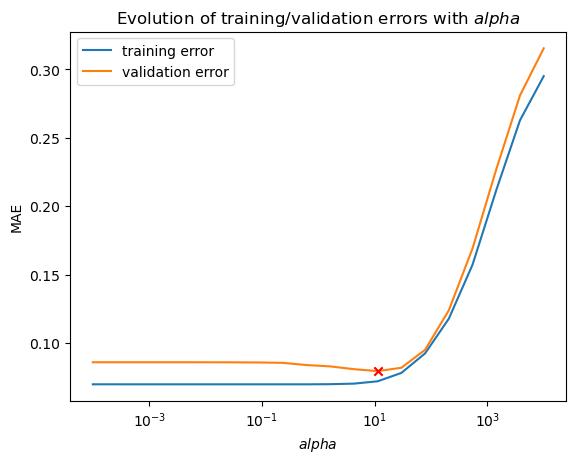

In [15]:
# Plot train and validation curves
plt.semilogx(
    cv_results["param_ridge__alpha"],
    -cv_results["mean_train_score"],
    label="training error",
)
plt.semilogx(
    cv_results["param_ridge__alpha"],
    -cv_results["mean_test_score"],
    label="validation error",
)

# Add marker for best score
plt.scatter(
    model_ridge.best_params_.values(),
    -1 * model_ridge.best_score_,
    marker="x",
    c="red",
    zorder=10,
)
plt.xlabel("$alpha$")
plt.ylabel("MAE")
plt.title("Evolution of training/validation errors with $alpha$")

plt.legend()
plt.show()

### Observation :  
The MAE remains stable for small values of alpha and starts to increase significantly when alpha becomes too large.  
The optimal performance is reached around alpha ≈ 10, where the validation error is minimized.  

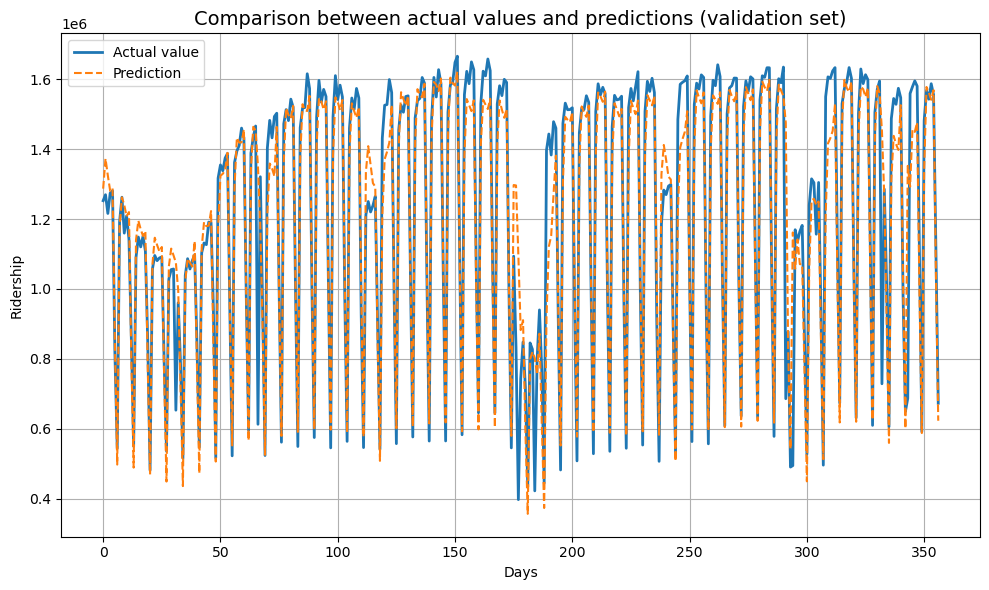

In [16]:
# Revenir à l'échelle réelle
y_valid_real = np.exp(y_te)
y_pred_real = np.exp(y_te_pred_log)


plt.figure(figsize=(10, 6))
plt.plot(y_valid_real.values, label='Actual value', linewidth=2)
plt.plot(y_pred_real, label='Prediction', linestyle='--')
plt.title('Comparison between actual values and predictions (validation set)', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observation :  
The model captures the general dynamics of daily ridership well, including seasonal variations and weekly patterns.  
However, discrepancies remain during some peaks and troughs, where the predictions tend to underestimate or overestimate the actual values.  


# 5) Analyzing the influence of weather

Does weather have an influence on passenger counts?  
We have seen that the correlation between weather and ridership is very weak.  
The question is whether this characteristic remains true when using a model such as Ridge regression.  

In [17]:
# Liste des features (version log pour les séries temporelles)
features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'indice_jour_semaine',
    'indice_semaine',
    'mois',
    'annee',
    'est_weekend',
    'est_ferie',
    'weather_code'
]

target = 'log_frequentation_totale'

# Définition des jeux de données
X_tr = train[features]
y_tr = train[target]

X_te = test[features]
y_te = test[target]

X_tr.head()

cat_features = ['mois', 'indice_jour_semaine', 'annee', 'weather_code']
num_features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'est_weekend',
    'est_ferie'
]

# Define the transformer
cat_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline([("scaler", StandardScaler())])

# Apply
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)


# Create the pipeline
pipe_ridge = Pipeline([("preprocessor", preprocessor), ("ridge", Ridge())])

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=5)  # 1 month validation , test_size=182

# Create grid for alpha
grid = {"ridge__alpha": np.logspace(-4, 4, num=20)}

# Create the grid search object
model_ridge = GridSearchCV(
    pipe_ridge,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

# Fit on the training set
model_ridge.fit(X_tr, y_tr)

# Evaluate on the test set
y_te_pred_log = model_ridge.predict(X_te)

ridge_w_model_name = "ridge with weather"
ridge_w_mae_log, ridge_w_rmse_log, ridge_w_r2_log,ridge_w_mae_real, ridge_w_rmse_real, ridge_w_r2_real = compute_statistics(ridge_w_model_name, y_te, y_te_pred_log)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
ridge with weather (log space):
  MAE : 0.0706
  RMSE: 0.1362
  R²  : 0.8701


ridge with weather (real space):
  MAE : 75725.2624
  RMSE: 130544.9033
  R²  : 0.8810


| Variante                         | RMSE (log) | MAE (log) | R²     | RMSE (réel) | MAE (réel)  | R²     |
|----------------------------------|------------|-----------|--------|--------------|-------------|--------|
| Baseline                        | **0.3827**  | **0.3015** | **-0.0248** | **378400.1933**  | **331204.8454**   | **-0.0001**|
| ridge sans météo                 | 0.1362     | 0.0702    | 0.8702 | 130343.4130  | 75017.5051 |  0.8813  |
| ridge with `weather_code`    | 0.1362     | 0.0706    | 0.8701 | 130544.9033  | 75725.2624 |  0.8810  |

### Observation :  
Including weather features does not produce any significant improvement in the model’s performance.  

### Question :  
Which features are the most influential?  

### Action :  
Analyze feature importance to identify the variables that contribute the most to the prediction.  

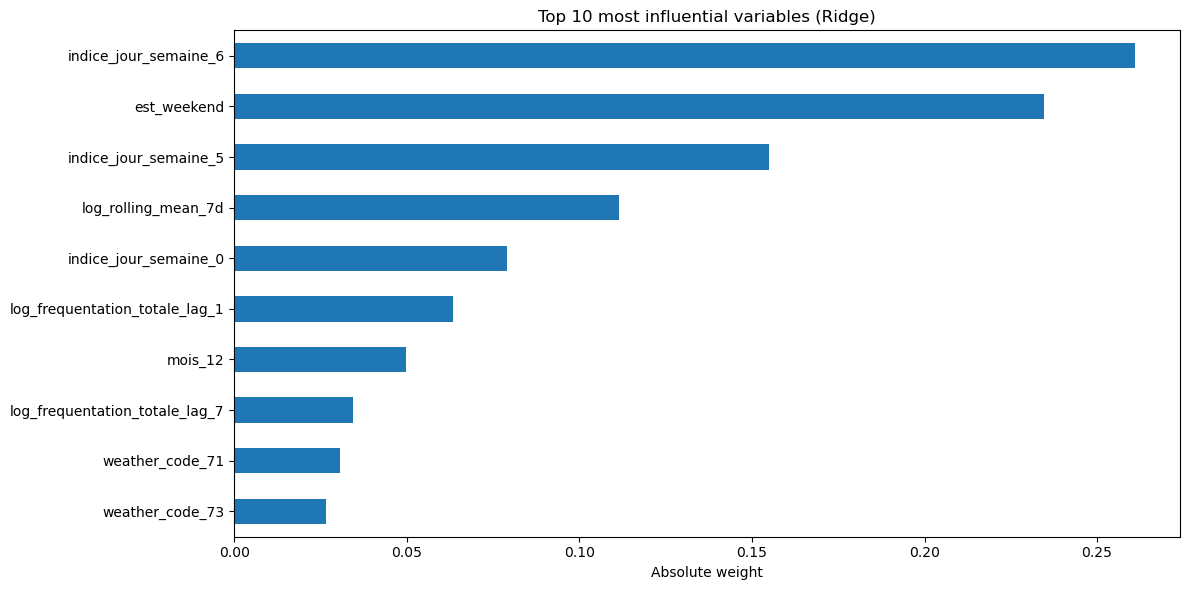

In [18]:
# code by chatGPT 
# Récupération des coefficients
coefs = model_ridge.best_estimator_.named_steps['ridge'].coef_

# Récupération des noms de features après preprocessing
onehot_feature_names = model_ridge.best_estimator_.named_steps['preprocessor']\
    .transformers_[0][1].named_steps['onehot']\
    .get_feature_names_out(cat_features)

all_feature_names = np.concatenate([onehot_feature_names, num_features])

# Création d'une série triée par valeur absolue
coef_series = pd.Series(coefs, index=all_feature_names)
coef_series_abs = coef_series.abs().sort_values(ascending=False)

coef_series_abs.head(10).sort_values().plot(
    kind='barh', figsize=(12, 6), title="Top 10 most influential variables (Ridge)"
)
plt.xlabel("Absolute weight")
plt.tight_layout()
plt.show()

### Observation :  
- The most influential variables are linked to the **day of the week** (`indice_jour_semaine_6`, `indice_jour_semaine_5`, `indice_jour_semaine_0`) and the **weekend indicator** (`est_weekend`).  
- Temporal features such as the **7-day rolling mean** and lagged passenger counts (`log_frequentation_totale_lag_1`, `log_frequentation_totale_lag_7`) also play an important role.  
- Weather variables (`weather_code_71`, `weather_code_73`) appear in the Top 10 but with relatively low influence.  

### Conclusion :  
Weekly seasonality and past ridership values are the dominant drivers in the Ridge model, while the impact of weather remains marginal.  

# 6) Decision Trees

Decision Trees are non-linear models that split the feature space into regions using recursive rules.  
They can capture interactions and non-linear effects without feature scaling.

In [19]:
from sklearn.tree import DecisionTreeRegressor

# Liste des features (version log pour les séries temporelles)
features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'indice_jour_semaine',
    'indice_semaine',
    'mois',
    'annee',
    'est_weekend',
    'est_ferie',
    'weather_code'
]

target = 'log_frequentation_totale'

# Définition des jeux de données
X_tr = train[features]
y_tr = train[target]

X_te = test[features]
y_te = test[target]

X_tr.head()

cat_features = ['mois', 'indice_jour_semaine', 'annee', 'weather_code']
num_features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'est_weekend',
    'est_ferie'
]

# Define the transformer
cat_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline([("scaler", StandardScaler())])

# Apply
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# Create the pipeline
pipe_ridge = Pipeline([("preprocessor", preprocessor), ("decisionTree", DecisionTreeRegressor(random_state=42))])

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=5)  # 1 month validation , test_size=182

# Create grid for alpha
grid = {"decisionTree__max_depth": [3, 5, 7, 8, 9, 10, 11, 12, 15, 20, None] }

# Create the grid search object
model = GridSearchCV(
    pipe_ridge,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

# Fit on the training set
model.fit(X_tr, y_tr)

# Evaluate on the test set
y_te_pred_log = model.predict(X_te)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


In [20]:
#display(model.cv_results_)

# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_decisionTree__max_depth",
]
cv_results[cols].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_decisionTree__max_depth
5,-0.096329,0.030621,-0.009042,0.004387,10
4,-0.096788,0.029723,-0.014471,0.006790,9
9,-0.097480,0.029137,-0.000020,0.000024,20
8,-0.098462,0.026859,-0.000951,0.000602,15
10,-0.098922,0.028093,0.000000,0.000000,None


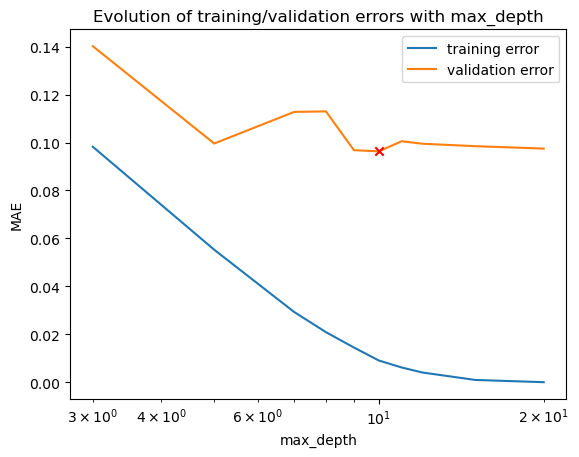

In [21]:
# Plot train and validation curves
plt.semilogx(
    cv_results["param_decisionTree__max_depth"],
    -cv_results["mean_train_score"],
    label="training error",
)
plt.semilogx(
    cv_results["param_decisionTree__max_depth"],
    -cv_results["mean_test_score"],
    label="validation error",
)

# Add marker for best score
plt.scatter(
    model.best_params_.values(),
    -1 * model.best_score_,
    marker="x",
    c="red",
    zorder=10,
)
plt.xlabel("max_depth")
plt.ylabel("MAE")
plt.title("Evolution of training/validation errors with max_depth")

plt.legend()
plt.show()

**Observation**  
We observe a continuous decrease in training error as `max_depth` increases, indicating that the tree is learning more and more details.  
The validation error reaches a minimum around `max_depth ≈ 10`, then stabilizes, suggesting that deeper trees do not bring further improvement and may lead to overfitting.  

**Conclusion**  
The optimal choice of `max_depth` is around 10, providing a good balance between bias and variance.


In [22]:
# model.best_params_

# Fit on the training set
# model.fit(X_tr, y_tr)
# GridSearchCV réentraîne automatiquement un modèle final avec ces best_params_ sur tout le jeu X_tr

# Evaluate on the test set
y_te_pred_log = model.predict(X_te)

dt_model_name = "decision tree"
dt_mae_log, dt_rmse_log, dt_r2_log,dt_mae_real, dt_rmse_real, dt_r2_real = compute_statistics(dt_model_name, y_te, y_te_pred_log)


decision tree (log space):
  MAE : 0.0653
  RMSE: 0.1456
  R²  : 0.8516


decision tree (real space):
  MAE : 68430.1350
  RMSE: 146487.1440
  R²  : 0.8501


# 7) Random Forest

Random Forest is an ensemble method that averages multiple decision trees to reduce variance and improve generalization.  
It should mitigate the overfitting we observed with single Decision Trees.

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Liste des features (version log pour les séries temporelles)
features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'indice_jour_semaine',
    'indice_semaine',
    'mois',
    'annee',
    'est_weekend',
    'est_ferie',
    'weather_code'
]

target = 'log_frequentation_totale'

# Définition des jeux de données
X_tr = train[features]
y_tr = train[target]

X_te = test[features]
y_te = test[target]

X_tr.head()

cat_features = ['mois', 'indice_jour_semaine', 'annee', 'weather_code']
num_features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'est_weekend',
    'est_ferie'
]

# Define the transformer
cat_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline([("scaler", StandardScaler())])

# Apply
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# Create the pipeline
pipe_ridge = Pipeline([("preprocessor", preprocessor), ("rfr", RandomForestRegressor(random_state=42, n_jobs=-1))])

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=5)  # 1 month validation , test_size=182

# Create grid for alpha
grid = {"rfr__n_estimators": [3, 5, 7, 8, 9, 10, 11, 12, 15, 20] }

# Create the grid search object
model = GridSearchCV(
    pipe_ridge,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

# Fit on the training set
model.fit(X_tr, y_tr)

# Evaluate on the test set
y_te_pred_log = model.predict(X_te)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [24]:
# display(model.cv_results_)

# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_rfr__n_estimators",
]
cv_results[cols].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_rfr__n_estimators
2,-0.082408,0.015472,-0.026857,0.001876,7
9,-0.083800,0.020017,-0.024483,0.001186,20
1,-0.083848,0.015843,-0.028327,0.002063,5
8,-0.083919,0.017706,-0.025504,0.002033,15
3,-0.084982,0.018365,-0.026572,0.002223,8


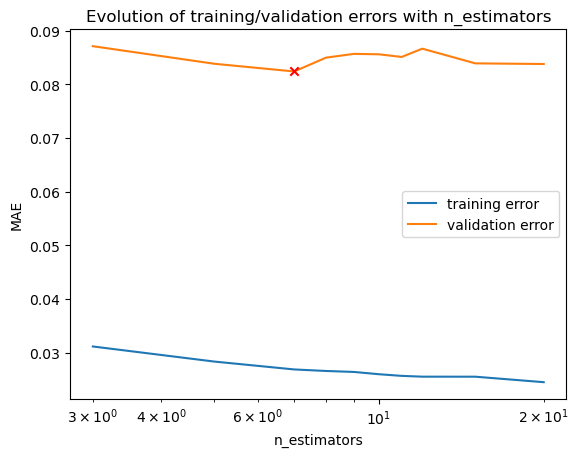

In [25]:
# Plot train and validation curves
plt.semilogx(
    cv_results["param_rfr__n_estimators"],
    -cv_results["mean_train_score"],
    label="training error",
)
plt.semilogx(
    cv_results["param_rfr__n_estimators"],
    -cv_results["mean_test_score"],
    label="validation error",
)

# Add marker for best score
plt.scatter(
    model.best_params_.values(),
    -1 * model.best_score_,
    marker="x",
    c="red",
    zorder=10,
)

plt.xlabel("n_estimators")
plt.ylabel("MAE")
plt.title("Evolution of training/validation errors with n_estimators")

plt.legend()
plt.show()

**Observation**  
The training error decreases slightly as `n_estimators` increases, showing that adding more trees helps capture more details.  
The validation error, however, remains relatively stable and reaches its minimum around `n_estimators ≈ 7–10`, suggesting that beyond this point additional trees do not significantly improve generalization.  

**Conclusion**  
A moderate number of trees (around 10) is sufficient to achieve good performance, while larger ensembles only increase computation time without clear benefits.

In [26]:
# model.best_params_

# Fit on the training set
# model.fit(X_tr, y_tr)
# GridSearchCV réentraîne automatiquement un modèle final avec ces best_params_ sur tout le jeu X_tr

# Evaluate on the test set
y_te_pred_log = model.predict(X_te)

rf_model_name = "random forest"
rf_mae_log, rf_rmse_log, rf_r2_log,rf_mae_real, rf_rmse_real, rf_r2_real = compute_statistics(rf_model_name, y_te, y_te_pred_log)



random forest (log space):
  MAE : 0.0611
  RMSE: 0.1253
  R²  : 0.8901


random forest (real space):
  MAE : 65138.3533
  RMSE: 126474.4065
  R²  : 0.8883


| Variante                         | RMSE (log) | MAE (log) | R²     | RMSE (réel) | MAE (réel)  | R²     |
|----------------------------------|------------|-----------|--------|--------------|-------------|--------|
| Baseline                        | **0.3827**  | **0.3015** | **-0.0248** | **378400.1933**  | **331204.8454**   | **-0.0001**|
| ridge sans météo                 | 0.1362     | 0.0702    | 0.8702 | 130343.4130  | 75017.5051 |  0.8813  |
| `weather_code` One-Hot Encoded   | 0.1362     | 0.0706    | 0.8701 | 130544.9033  | 75725.2624 |  0.8810  |
| decision tree                    | 0.1456     | 0.0653    | 0.8516 | 146487.1440  | 68430.1350 |  0.8501  |
| random forest                    | 0.1253     | 0.0611    | 0.8901 | 126474.4065  | 65138.3533 |  0.8883  |

# 8) Features explication with SHAP

**Observation**   
During a recent conference, SHAP was presented as a powerful tool to explain model predictions by quantifying feature importance.
This motivated me to apply SHAP in my own analysis, in order to better understand the contribution of each variable to the Random Forest model’s predictions.

SHAP version : 0.48.0
X_transformed (real type): <class 'scipy.sparse.csr.csr_matrix'>
X_transformed shape: (1058, 41)
len(all_feature_names): 41


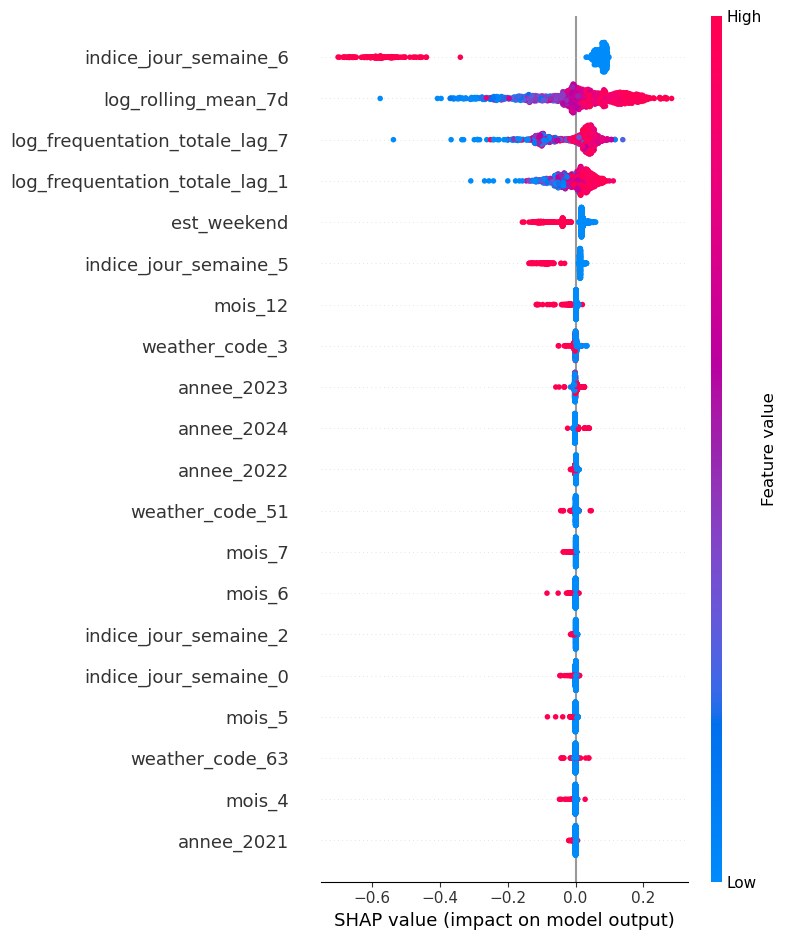

In [27]:
# code by chatGPT

import shap
print("SHAP version :", shap.__version__)

# Étape 1 : pipeline complet
pipe = model.best_estimator_
preprocessor = pipe.named_steps['preprocessor']
best_rfr = pipe.named_steps['rfr']

# Étape 2 : application correcte du préprocessing
X_transformed = preprocessor.transform(X_tr)

# Vérification vraie forme
print("X_transformed (real type):", type(X_transformed))
print("X_transformed shape:", X_transformed.shape)

# Étape 3 : noms de colonnes
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
onehot_feature_names = onehot_encoder.get_feature_names_out(cat_features)
all_feature_names = np.concatenate([onehot_feature_names, num_features])

print("len(all_feature_names):", len(all_feature_names))

# Étape 4 : conversion explicite en array dense si sparse matrix
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# Étape 5 : DataFrame SHAP
X_shap = pd.DataFrame(X_transformed, columns=all_feature_names)

# Étape 6 : SHAP
explainer = shap.Explainer(best_rfr, X_shap)
shap_values = explainer(X_shap)

# Étape 7 : Affichage
shap.summary_plot(shap_values.values, X_shap, feature_names=all_feature_names, show=False)

# Sauvegarde d'abord (sans show)
plt.tight_layout()
# plt.savefig("shap_summary_plot_randomforest.png", dpi=300, bbox_inches="tight")


plt.show()




**Observation**  
SHAP values show that weekly seasonality dominates the predictions, with Sunday (`indice_jour_semaine_6`) strongly reducing ridership.  
Lagged and rolling features (`log_rolling_mean_7d`, `log_frequentation_totale_lag_1`, `lag_7`) also play a major role, highlighting temporal dependencies.  
Calendar effects (weekend, Saturday, December) are important, while weather variables have a moderate influence.  
Year indicators contribute little, suggesting stable long-term trends.

**Conclusion**  
We observe that the most important features identified by SHAP (weekly seasonality, lagged ridership, and rolling averages) are consistent with those highlighted by the Ridge model.  
This confirms that calendar effects and temporal dependencies dominate daily ridership dynamics, while weather remains a secondary factor.

# 8) k-Nearest Neighbors (k-NN)

k-NN is a non-parametric algorithm that makes predictions by averaging the target values of the *k* most similar training samples.  
It can capture local patterns in the data, but its performance strongly depends on feature scaling and the choice of *k*.  

In [28]:
from sklearn.neighbors import KNeighborsRegressor
import time

# Liste des features (version log pour les séries temporelles)
features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'indice_jour_semaine',
    'indice_semaine',
    'mois',
    'annee',
    'est_weekend',
    'est_ferie',
    'weather_code'
]

target = 'log_frequentation_totale'

# Définition des jeux de données
X_tr = train[features]
y_tr = train[target]

X_te = test[features]
y_te = test[target]

X_tr.head()

cat_features = ['mois', 'indice_jour_semaine', 'annee', 'weather_code']
num_features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'est_weekend',
    'est_ferie'
]

# Define the transformer
cat_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown='ignore', sparse=False))])
num_transformer = Pipeline([("scaler", StandardScaler())])

# Apply
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# Create the pipeline
pipe_ridge = Pipeline([("preprocessor", preprocessor), ("knn", KNeighborsRegressor(n_jobs=-1))])

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=5)  # 1 month validation , test_size=182

# Create grid for alpha
grid = {
    "knn__n_neighbors": [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 20],
    "knn__weights": ["uniform", "distance"],
    "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}

start_time = time.time()
# Create the grid search object
model = GridSearchCV(
    pipe_ridge,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

# Fit on the training set
model.fit(X_tr, y_tr)

# Evaluate on the test set
y_te_pred_log = model.predict(X_te)

end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

print("Best Params:", model.best_params_)
print("Best Score:", -model.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Total execution time: 17.11 seconds
Best Params: {'knn__algorithm': 'auto', 'knn__n_neighbors': 8, 'knn__weights': 'uniform'}
Best Score: 0.0925415643406117


In [29]:
# display(model.cv_results_)

# Collect results in a DataFrame
cv_results = pd.DataFrame(model.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_knn__n_neighbors",
    "param_knn__weights",
    "param_knn__algorithm",
]
cv_results[cols].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_knn__n_neighbors,param_knn__weights,param_knn__algorithm
10,-0.092542,0.012462,-0.061822,0.001028,8,uniform,auto
58,-0.092542,0.012462,-0.061822,0.001028,8,uniform,kd_tree
82,-0.092542,0.012462,-0.061822,0.001028,8,uniform,brute
34,-0.092542,0.012462,-0.061822,0.001028,8,uniform,ball_tree
35,-0.092579,0.012886,0.000000,0.000000,8,distance,ball_tree


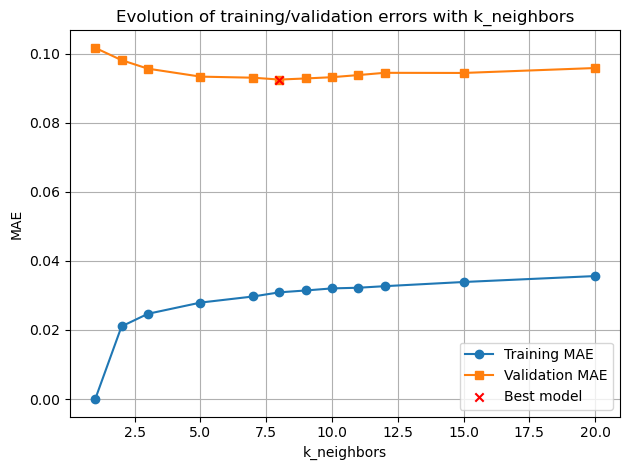

In [30]:
# Agréger les scores par n_neighbors (moyenne sur toutes les combinaisons weights/algorithm)
agg_results = cv_results.groupby("param_knn__n_neighbors").mean(numeric_only=True).reset_index()

# Tracer les courbes avec données agrégées
plt.plot(
    agg_results["param_knn__n_neighbors"],
    -agg_results["mean_train_score"],
    label="Training MAE",
    marker="o"
)
plt.plot(
    agg_results["param_knn__n_neighbors"],
    -agg_results["mean_test_score"],
    label="Validation MAE",
    marker="s"
)

# Marqueur pour le meilleur modèle
best_n = model.best_params_["knn__n_neighbors"]
best_score = -model.best_score_

plt.scatter(
    best_n,
    best_score,
    marker="x",
    c="red",
    zorder=10,
    label="Best model"
)

plt.xlabel("k_neighbors")
plt.ylabel("MAE")
plt.title("Evolution of training/validation errors with k_neighbors")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Observation**  
The training error increases with larger values of `k`, as predictions become smoother and less adapted to individual cases.  
The validation error reaches its minimum around `k ≈ 8`, then stabilizes, showing that increasing the number of neighbors beyond this point does not improve generalization.  

**Conclusion**  
A moderate value of `k` (around 8) offers the best trade-off between underfitting (large `k`) and overfitting (small `k`).


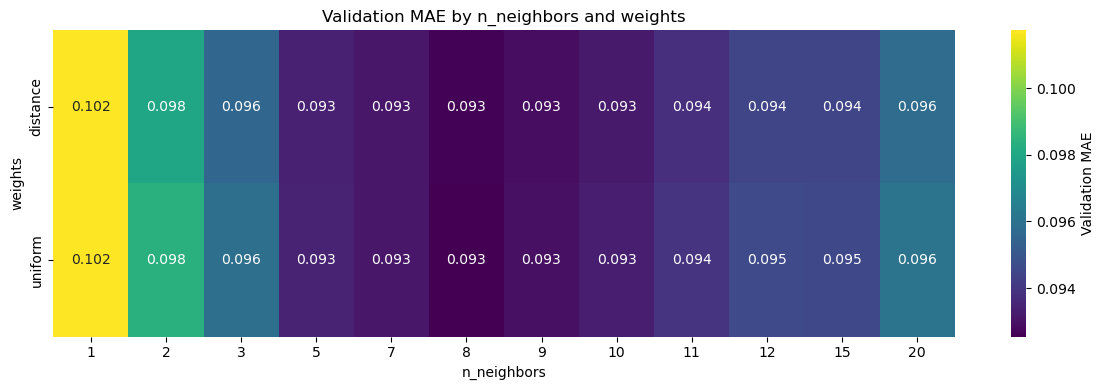

In [31]:
# Étape 1 : DataFrame avec les bons paramètres
heatmap_data = cv_results[[
    "param_knn__n_neighbors",
    "param_knn__weights",
    "mean_test_score"
]].copy()

# Convertir en MAE
heatmap_data["MAE"] = -heatmap_data["mean_test_score"]

# Étape 2 : grouper et agréger
grouped = heatmap_data.groupby(
    ["param_knn__weights", "param_knn__n_neighbors"]
).mean(numeric_only=True).reset_index()

# Étape 3 : pivot pour la heatmap
pivot = grouped.pivot(
    index="param_knn__weights",
    columns="param_knn__n_neighbors",
    values="MAE"
)

# Étape 4 : tracer
plt.figure(figsize=(12, 4))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={'label': 'Validation MAE'}
)
plt.title("Validation MAE by n_neighbors and weights")
plt.xlabel("n_neighbors")
plt.ylabel("weights")
plt.tight_layout()
plt.show()

**Observation**  
The heatmap shows very similar validation MAE values for both `uniform` and `distance` weighting strategies.  
This indicates that weighting neighbors by distance does not provide a clear advantage over simple averaging in this dataset.  
The best performance is reached around `n_neighbors ≈ 7–9`, regardless of the weighting scheme.  

**Conclusion**  
The choice of `weights` has little influence on model performance.  
The main driver of accuracy is the number of neighbors, with an optimal range around 7–9.


In [32]:
# model.best_params_

# Fit on the training set
# model.fit(X_tr, y_tr)
# GridSearchCV réentraîne automatiquement un modèle final avec ces best_params_ sur tout le jeu X_tr

# Evaluate on the test set
y_te_pred_log = model.predict(X_te)

knn_model_name = "k-Nearest Neighbors (k-NN)"
knn_mae_log, knn_rmse_log, knn_r2_log,knn_mae_real, knn_rmse_real, knn_r2_real = compute_statistics(knn_model_name, y_te, y_te_pred_log)


k-Nearest Neighbors (k-NN) (log space):
  MAE : 0.0728
  RMSE: 0.1286
  R²  : 0.8843


k-Nearest Neighbors (k-NN) (real space):
  MAE : 83232.0860
  RMSE: 130007.0883
  R²  : 0.8820


# 9) Neural Networks (MLP)

Multi-Layer Perceptrons (MLP) are feedforward neural networks that can model complex, non-linear relationships.  
Unlike tree-based models, they require careful preprocessing (scaling) and are sensitive to hyperparameters (architecture, activation functions, learning rate, etc.).

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import time

# Liste des features (version log pour les séries temporelles)
features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'indice_jour_semaine',
    'indice_semaine',
    'mois',
    'annee',
    'est_weekend',
    'est_ferie',
    'weather_code'
]

target = 'log_frequentation_totale'

# Définition des jeux de données
X_tr = train[features]
y_tr = train[target]

X_te = test[features]
y_te = test[target]

X_tr.head()

cat_features = ['mois', 'indice_jour_semaine', 'annee', 'weather_code']
num_features = [
    'log_frequentation_totale_lag_1',
    'log_frequentation_totale_lag_7',
    'log_rolling_mean_7d',
    'est_weekend',
    'est_ferie'
]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

X_tr_transformed = preprocessor.fit_transform(X_tr)
X_te_transformed = preprocessor.transform(X_te)

# Modèle Keras
def build_model():
    model = Sequential([
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model = build_model()

history = model.fit(
    X_tr_transformed, y_tr,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


2025-08-30 12:18:46.374576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-30 12:18:46.374614: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-08-30 12:18:48.595194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-08-30 12:18:48.595234: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-08-30 12:18:48.595258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vmdevpc): /proc/driver/nvidia/version does not exist
2025-08-30 12:18:48.595482: I tensorflow/core/platform/cpu_feature_gu

Epoch 1/200
53/53 [==============================] - 0s 3ms/step - loss: 148.0041 - mae: 12.0748 - val_loss: 99.1948 - val_mae: 9.9184
Epoch 2/200
53/53 [==============================] - 0s 2ms/step - loss: 29.5058 - mae: 4.5023 - val_loss: 5.4220 - val_mae: 2.0713
Epoch 3/200
53/53 [==============================] - 0s 2ms/step - loss: 3.2332 - mae: 1.4256 - val_loss: 5.8116 - val_mae: 2.1997
Epoch 4/200
53/53 [==============================] - 0s 1ms/step - loss: 2.4962 - mae: 1.2493 - val_loss: 6.1190 - val_mae: 2.2740
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 2.0873 - mae: 1.1447 - val_loss: 5.7103 - val_mae: 2.2085
Epoch 6/200
53/53 [==============================] - 0s 1ms/step - loss: 2.0313 - mae: 1.1307 - val_loss: 5.5465 - val_mae: 2.1840
Epoch 7/200
53/53 [==============================] - 0s 1ms/step - loss: 2.1146 - mae: 1.1591 - val_loss: 5.3018 - val_mae: 2.1263
Epoch 8/200
53/53 [==============================] - 0s 2ms/step - loss: 1.796

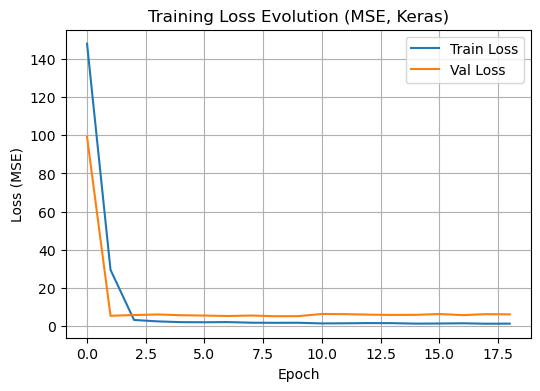

In [34]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Evolution (MSE, Keras)")
plt.legend()
plt.grid(True)
plt.show()

**Observation**  
The training and validation losses decrease very quickly within the first few epochs and then stabilize close to zero.  
This indicates that the MLP rapidly fits the dataset and reaches convergence without signs of overfitting, as training and validation curves overlap.  

**Conclusion**  
The neural network is able to learn the patterns in the data efficiently, but the rapid convergence suggests that the problem is relatively simple for the chosen architecture.


In [35]:
# model.best_params_

# Fit on the training set
# model.fit(X_tr, y_tr)
# GridSearchCV réentraîne automatiquement un modèle final avec ces best_params_ sur tout le jeu X_tr

# Evaluate on the test set
y_te_pred_log = model.predict(X_te_transformed).flatten()

MLP_model_name = "Neural Networks (MLP)"
MLP_mae_log, MLP_rmse_log, MLP_r2_log,MLP_mae_real, MLP_rmse_real, MLP_r2_real = compute_statistics(MLP_model_name, y_te, y_te_pred_log)


Neural Networks (MLP) (log space):
  MAE : 2.2464
  RMSE: 2.3385
  R²  : -37.2677


Neural Networks (MLP) (real space):
  MAE : 1071224.0166
  RMSE: 1124704.3436
  R²  : -7.8349


# 10) Neural Network Optimization with GridSearchCV

In this section, we use GridSearchCV to optimize the hyperparameters of our neural network (batch size, epochs, optimizer, dropout rate) in order to identify the best configuration and improve predictive performance.

In [36]:
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

In [37]:
def build_model_best(optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(41,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # régression
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [38]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

keras_reg = KerasRegressor(build_fn=build_model_best, verbose=0)

param_grid = {
    'batch_size': [32, 64],
    'epochs': [100, 200],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.0, 0.2, 0.3],
}

grid = GridSearchCV(estimator=keras_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_result = grid.fit(X_tr_transformed, y_tr)

In [39]:
print("Best score (neg MAE):", grid_result.best_score_)
print("Best params:", grid_result.best_params_)

Best score (neg MAE): -0.6575369772106874
Best params: {'batch_size': 64, 'dropout_rate': 0.0, 'epochs': 100, 'optimizer': 'adam'}


In [40]:
final_model = build_model_best(optimizer='rmsprop', dropout_rate=0.3)

history = final_model.fit(
    X_tr_transformed, y_tr,
    epochs=200,
    batch_size=32,
    validation_split=0.2,  # ou 0 si tu veux tout utiliser
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/200
27/27 [==============================] - 0s 3ms/step - loss: 109.9767 - mae: 10.2522 - val_loss: 53.6690 - val_mae: 7.2462
Epoch 2/200
27/27 [==============================] - 0s 1ms/step - loss: 11.5752 - mae: 2.7877 - val_loss: 8.9103 - val_mae: 2.7717
Epoch 3/200
27/27 [==============================] - 0s 1ms/step - loss: 2.1685 - mae: 1.1730 - val_loss: 8.0709 - val_mae: 2.6562
Epoch 4/200
27/27 [==============================] - 0s 1ms/step - loss: 1.8918 - mae: 1.1180 - val_loss: 6.4332 - val_mae: 2.3956
Epoch 5/200
27/27 [==============================] - 0s 1ms/step - loss: 1.5768 - mae: 0.9946 - val_loss: 8.2795 - val_mae: 2.6942
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 1.4653 - mae: 0.9508 - val_loss: 7.9817 - val_mae: 2.6589
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 1.3813 - mae: 0.9429 - val_loss: 9.5774 - val_mae: 2.9103
Epoch 8/200
27/27 [==============================] - 0s 1ms/step - loss: 1.268

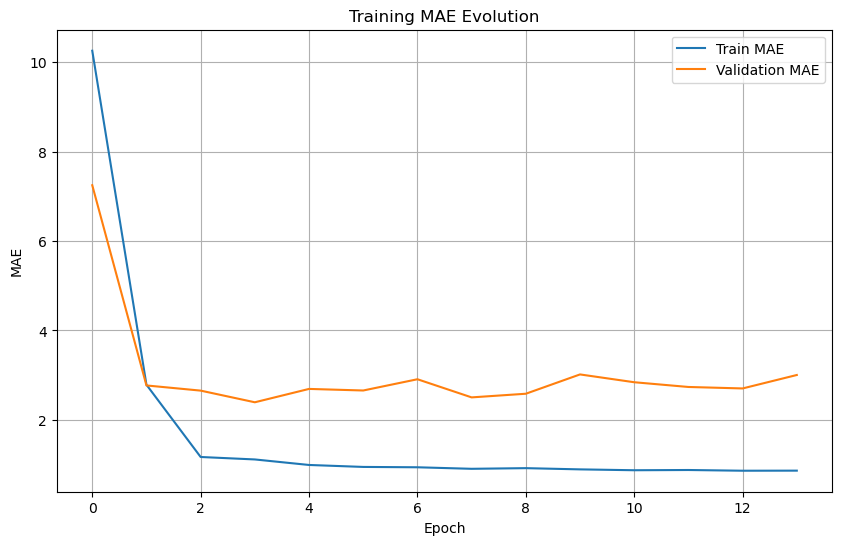

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title("Training MAE Evolution")
plt.legend()
plt.grid(True)
plt.show()

**Observation**  
A grid search was performed over different hyperparameters (batch size, number of epochs, optimizer, and dropout rate) to optimize the neural network.  
The results show that the model benefits from regularization (dropout) and that the choice of optimizer (`adam` vs `rmsprop`) can have a noticeable impact on performance.  
The training and validation curves indicate that the model converges well, with early stopping preventing overfitting.  


In [42]:
# model.best_params_

# Fit on the training set
# model.fit(X_tr, y_tr)
# GridSearchCV réentraîne automatiquement un modèle final avec ces best_params_ sur tout le jeu X_tr

# Evaluate on the test set
y_te_pred_log = final_model.predict(X_te_transformed).flatten()

BNN_model_name = "Best Neural Networks"
BNN_mae_log, BNN_rmse_log, BNN_r2_log,BNN_mae_real, BNN_rmse_real, BNN_r2_real = compute_statistics(BNN_model_name, y_te, y_te_pred_log)



Best Neural Networks (log space):
  MAE : 2.1267
  RMSE: 2.2417
  R²  : -34.1652


Best Neural Networks (real space):
  MAE : 1042185.3177
  RMSE: 1097490.9116
  R²  : -7.4126


# 11) Model Comparison

After training and tuning several models (Baseline, Ridge, Decision Trees, Random Forest, k-NN, Neural Networks), we compare their performances side by side.  
The goal is to identify which approach provides the best trade-off between accuracy, interpretability, and computational cost.  

In [43]:
from IPython.display import Markdown, display

table = f"""
| Variante | RMSE (log) | MAE (log) | R² | RMSE (réel) | MAE (réel) | R² |
|---|---|---|---|---|---|---|
| **Baseline** | **{base_rmse_log:.4f}** | **{base_mae_log:.4f}** | **{base_r2_log:.4f}** | **{base_rmse_real:,.2f}** | **{base_mae_real:,.2f}** | **{base_r2_real:.4f}** |
| Ridge sans météo | {ridge_rmse_log:.4f} | {ridge_mae_log:.4f} | {ridge_r2_log:.4f} | {ridge_rmse_real:,.2f} | {ridge_mae_real:,.2f} | {ridge_r2_real:.4f} |
| {ridge_w_model_name} | {ridge_w_rmse_log:.4f} | {ridge_w_mae_log:.4f} | {ridge_w_r2_log:.4f} | {ridge_w_rmse_real:,.2f} | {ridge_w_mae_real:,.2f} | {ridge_w_r2_real:.4f} |
| {dt_model_name} | {dt_rmse_log:.4f} | {dt_mae_log:.4f} | {dt_r2_log:.4f} | {dt_rmse_real:,.2f} | {dt_mae_real:,.2f} | {dt_r2_real:.4f} |
| **{rf_model_name}** | **{rf_rmse_log:.4f}** | **{rf_mae_log:.4f}** | **{rf_r2_log:.4f}** | **{rf_rmse_real:,.2f}** | **{rf_mae_real:,.2f}** | **{rf_r2_real:.4f}** |
| {knn_model_name} | {knn_rmse_log:.4f} | {knn_mae_log:.4f} | {knn_r2_log:.4f} | {knn_rmse_real:,.2f} | {knn_mae_real:,.2f} | {knn_r2_real:.4f} |
| {MLP_model_name} | {MLP_rmse_log:.4f} | {MLP_mae_log:.4f} | {MLP_r2_log:.4f} | {MLP_rmse_real:,.2f} | {MLP_mae_real:,.2f} | {MLP_r2_real:.4f} |
| {BNN_model_name} | {BNN_rmse_log:.4f} | {BNN_mae_log:.4f} | {BNN_r2_log:.4f} | {BNN_rmse_real:,.2f} | {BNN_mae_real:,.2f} | {BNN_r2_real:.4f} |
"""
display(Markdown(table))


| Variante | RMSE (log) | MAE (log) | R² | RMSE (réel) | MAE (réel) | R² |
|---|---|---|---|---|---|---|
| **Baseline** | **0.3827** | **0.3015** | **-0.0248** | **378,400.19** | **331,204.85** | **-0.0001** |
| Ridge sans météo | 0.1362 | 0.0702 | 0.8702 | 130,343.41 | 75,017.51 | 0.8813 |
| ridge with weather | 0.1362 | 0.0706 | 0.8701 | 130,544.90 | 75,725.26 | 0.8810 |
| decision tree | 0.1456 | 0.0653 | 0.8516 | 146,487.14 | 68,430.14 | 0.8501 |
| **random forest** | **0.1253** | **0.0611** | **0.8901** | **126,474.41** | **65,138.35** | **0.8883** |
| k-Nearest Neighbors (k-NN) | 0.1286 | 0.0728 | 0.8843 | 130,007.09 | 83,232.09 | 0.8820 |
| Neural Networks (MLP) | 2.3385 | 2.2464 | -37.2677 | 1,124,704.34 | 1,071,224.02 | -7.8349 |
| Best Neural Networks | 2.2417 | 2.1267 | -34.1652 | 1,097,490.91 | 1,042,185.32 | -7.4126 |


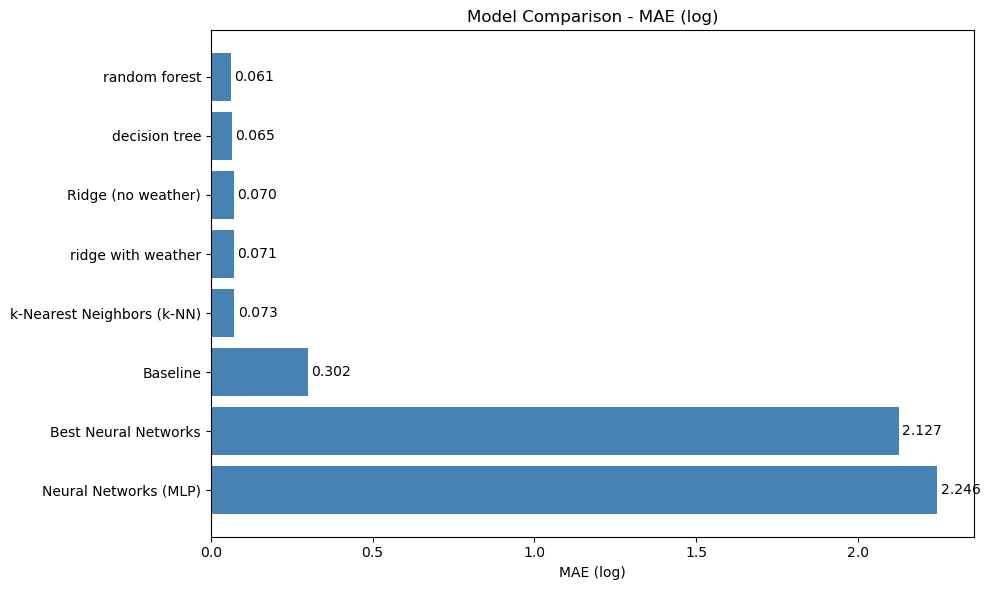

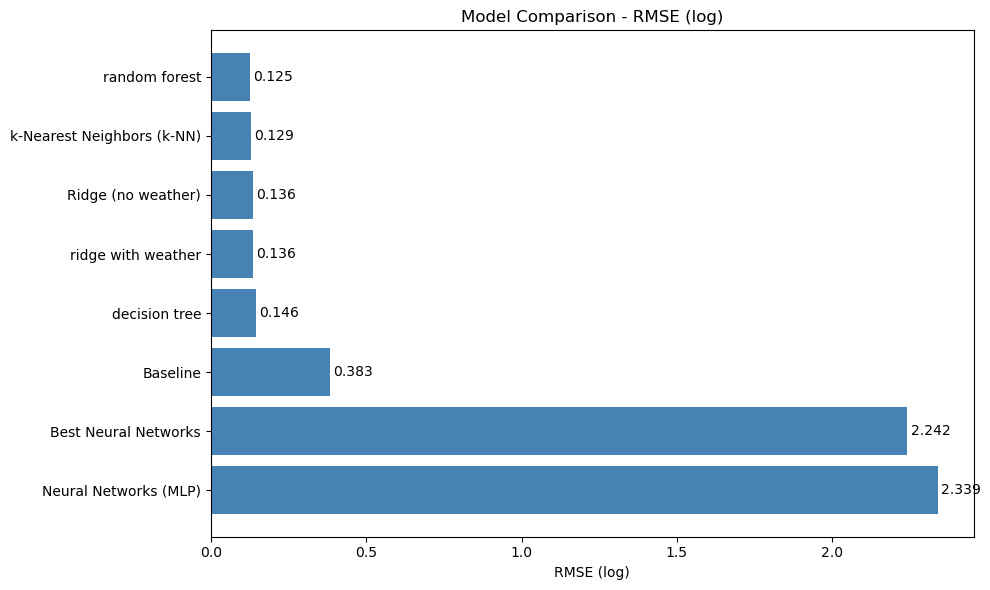

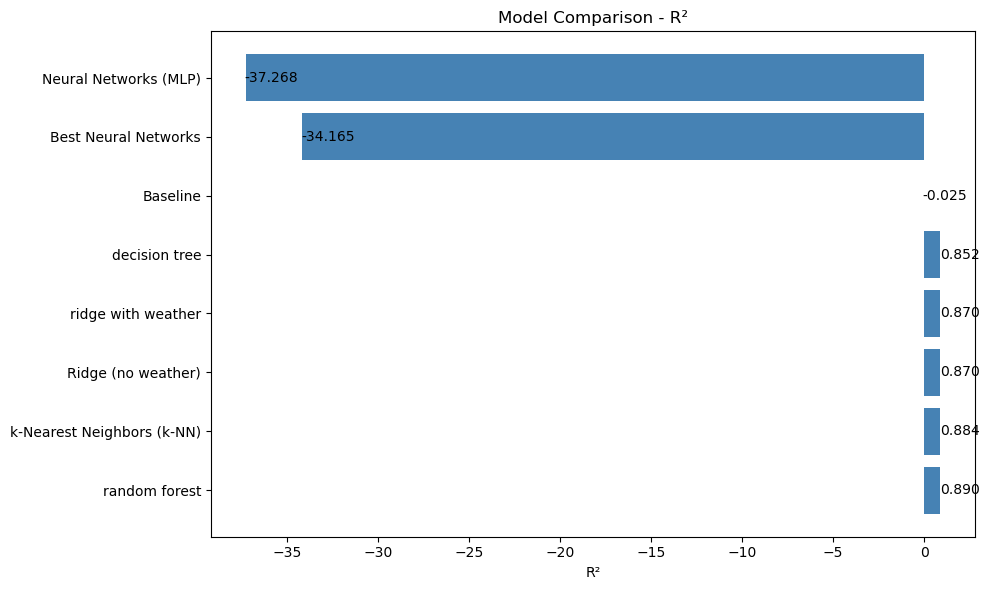

In [44]:
results = {
    "Variante": [
        "Baseline",
        "Ridge (no weather)",
        ridge_w_model_name,
        dt_model_name,
        rf_model_name,
        knn_model_name,
        MLP_model_name,
        BNN_model_name
    ],
    "RMSE (log)": [
        base_rmse_log,
        ridge_rmse_log,
        ridge_w_rmse_log,
        dt_rmse_log,
        rf_rmse_log,
        knn_rmse_log,
        MLP_rmse_log,
        BNN_rmse_log
    ],
    "MAE (log)": [
        base_mae_log,
        ridge_mae_log,
        ridge_w_mae_log,
        dt_mae_log,
        rf_mae_log,
        knn_mae_log,
        MLP_mae_log,
        BNN_mae_log
    ],
    "R²": [
        base_r2_log,
        ridge_r2_log,
        ridge_w_r2_log,
        dt_r2_log,
        rf_r2_log,
        knn_r2_log,
        MLP_r2_log,
        BNN_r2_log
    ]
}

df = pd.DataFrame(results)

# --- Fonction utilitaire pour tracer ---
def plot_barh_metric(df, metric, title, ascending=True):
    plot_df = df.sort_values(metric, ascending=ascending).copy()
    plt.figure(figsize=(10, 6))
    bars = plt.barh(plot_df["Variante"], plot_df[metric], color="steelblue")
    plt.xlabel(metric)
    plt.title(title)
    for bar in bars:
        width = bar.get_width()
        x_text = width + (0.01 if width >= 0 else -0.06)
        plt.text(x_text, bar.get_y() + bar.get_height()/2, f"{width:.3f}", va="center")
    if ascending:  # pour RMSE / MAE (plus petit est mieux)
        plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# --- Générer les graphes ---
plot_barh_metric(df, "MAE (log)", "Model Comparison - MAE (log)", ascending=True)
plot_barh_metric(df, "RMSE (log)", "Model Comparison - RMSE (log)", ascending=True)
plot_barh_metric(df, "R²", "Model Comparison - R²", ascending=False)  # pour R² plus grand = mieux


**Observation**  
- The **Baseline** shows very poor performance (R² ≈ 0), as expected.  
- **Ridge regression** (with or without weather) achieves good accuracy (MAE ≈ 0.070 in log space, R² ≈ 0.87). Weather features do not significantly change results.  
- The **Decision Tree** performs slightly worse than Ridge, confirming its tendency to overfit/underfit depending on depth.  
- The **Random Forest** is the best model overall, with the lowest errors (MAE ≈ 0.061 in log space, R² ≈ 0.89).  
- **k-NN** achieves competitive performance (MAE ≈ 0.073, R² ≈ 0.88), but is less efficient computationally.  
- **Neural Networks (MLP)** perform very poorly on this dataset, with negative R², showing overfitting or mismatch with the data structure.  
- Even after hyperparameter tuning, the **Best Neural Network** remains far below Ridge and Random Forest.

**Conclusion**  
Random Forest provides the **best compromise** between accuracy and robustness, followed closely by Ridge regression (simpler and more interpretable).  
Weather variables have **limited additional value**, while temporal and calendar features remain the dominant drivers.  

# 12) Conclusion

This study showed that predicting daily ridership on the TPG network is feasible with relatively high accuracy using classical machine learning models.  
The analysis confirms that **calendar and temporal features** (day of week, weekend effects, lagged values, rolling means) are the most influential drivers of demand.  
**Weather variables** do have an impact, but their contribution is secondary compared to strong seasonal patterns.  

Among the models tested, **Random Forest** provided the best trade-off between accuracy and robustness, while **Ridge Regression** offered a nearly equivalent performance with the added benefit of simplicity and interpretability.  
Other models such as k-NN and Decision Trees remained competitive but less optimal, and Neural Networks performed poorly in this context.  

Overall, this first stage validates the methodology and identifies the most promising models.  
Although **Random Forest** achieved the highest accuracy, its computational cost proved significant and some runs did not complete within a reasonable time.  
For this reason, the practical case study presented in the following chapter relies on **Ridge Regression**, which provides a strong balance between performance, interpretability, and efficiency.  

Let’s now move on to the practical case study in the next chapter.

In [45]:
#end